# Estimator Benchmarks

Notebook for benchmarking known IV estimators against different data generating processes.

Current roster:
- Split-sample IV **TODO**
- 2SLS
- Jackknife IV **TODO**
- LIML 
- Mostly harmless ML
- DeepIV **TODO**
- DoubleML **TODO**
- ML'd IV **TODO** Singh et al. 2023

# Imports

In [1]:
from glob import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm

In [2]:
from src.model import PoolingMLP
from src.data.lennon_iv_generator import LennonIVGenerator, generate_cov_matrix
from src.viz.plotting import kde_ridgeplot

# Load benchmarking results

In [3]:
result_dir = "../results/benchmark_lennon100/"

models = [
    "TSLS",
    "LIML",
    "OLS",
    "MHML"
]

benchmark_results = {
    model: pd.read_parquet(os.path.join(result_dir, f"{model}_results.parquet")) for model in models
}

In [15]:
MODEL_CHKPT = "/home/tliu/learning-ivs/workdir/pool_mlp_lennon_bs256_lr0.004_eps100_hidden256_depth4/ckpts/exp_name=pool_mlp_lennon_bs256_lr0.004_eps100_hidden256_depth4-val_loss=0.0070.ckpt"
data_dir = "/home/tliu/learning-ivs/datasets/linear/lennon100_fixed_tau/test"

model = PoolingMLP.load_from_checkpoint(MODEL_CHKPT)
model.eval();

/home/tliu/learning-ivs/src/model/pooling_mlp.py:109: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(m.weight)


In [16]:
pooled_mlp_preds = []

for file_name in tqdm(glob(f"{data_dir}/*.parquet")):
    df = pd.read_parquet(file_name)
    # pooled MLP
    data = torch.tensor(df.to_numpy(), dtype=torch.float32)
    #print(data.shape)
    # create a batch dimension
    data = data.unsqueeze(0)
    pooled_mlp_preds.append(model(data).squeeze().item())

100%|██████████| 1000/1000 [00:15<00:00, 65.13it/s]


In [18]:
benchmark_results["TSLS"].head()

,tau,se,ground_truth,idx,model
0,1.398952,0.084520,1.0,0,TSLS
1,1.486148,0.080369,1.0,1,TSLS
2,1.463310,0.076734,1.0,2,TSLS
3,1.403686,0.080071,1.0,3,TSLS
4,1.408438,0.068298,1.0,4,TSLS


In [19]:
result_df = pd.DataFrame()
for k, df in benchmark_results.items():
    df["model"] = k
    result_df = pd.concat([result_df, df[['tau', 'model']]])


In [20]:
pooled_df = pd.DataFrame(pooled_mlp_preds, columns=["tau"])
pooled_df["model"] = "Pooled MLP"
result_df = pd.concat([result_df, pooled_df])

In [21]:
pooled_df

,tau,model
0,1.202968,Pooled MLP
1,1.330552,Pooled MLP
2,1.240972,Pooled MLP
3,1.127863,Pooled MLP
4,1.141272,Pooled MLP
...,...,...
995,1.253130,Pooled MLP
996,1.226035,Pooled MLP
997,1.292876,Pooled MLP
998,1.165001,Pooled MLP


In [22]:
result_df.

(5000, 2)

In [23]:
result_df['model'].unique()

array(['TSLS', 'LIML', 'OLS', 'MHML', 'Pooled MLP'], dtype=object)

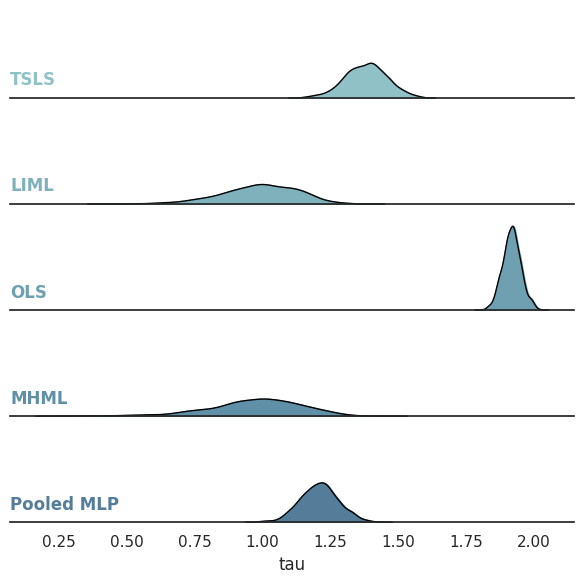

In [24]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
kde_ridgeplot(result_df, 'model', 'tau', pal, figsize=(6, 6))

## Sandbox for bias-var tradeoff

In [28]:
def mse_decomp(preds, ground_truth=1):
    """
    Quick function for computing MSE, bias^2, and variance.

    Args:
        preds: np.array of predictions
        ground_truth: if not a scalar, needs to be same shape as preds
    """
    assert np.isscalar(ground_truth) or preds.shape == ground_truth.shape

    mse = np.mean((preds - ground_truth)**2)
    bias = np.mean(preds) - ground_truth
    var = np.var(preds)

    return mse, bias, var


In [31]:
sel = result_df[result_df['model'] == 'OLS']
mse, bias, var = mse_decomp(sel['tau'])
print(mse)
print(bias)
print(var)
print(bias**2 + var)

0.8447172108665499
0.9184764352153716
0.0011182488206130019
0.8447172108665496


## Roadmap for leaderboarding

1. modify benchmark.py to compute mses/metrics for a specfic task
2. clean up the configs so that the correct experiment names are shown
3. Write to a results json that has the following format: 

```json
{
    "results": {
        "task_name1": {
            "metric_name": 0
        }
    }
}
```

Also look at the formatting of the demo-leaderboard-backend/results dataset: https://huggingface.co/datasets/demo-leaderboard-backend/results?row=1

# Lennon et al. 2022 Replication

In [21]:
n_samples = 1000
mu2 = 180
n_instruments = 100
iv_gen = LennonIVGenerator(
            tau_range=[1,1],
            max_vars=n_instruments,
            n_instruments=n_instruments,
            #instrument_covariance=torch.Tensor(generate_cov_matrix(n_instruments)), 
            instrument_cov_base=0.5,
            instrument_strength=mu2/n_samples,
        )

data = iv_gen.batch(tau=1, batch_size=n_samples).detach().numpy()

In [22]:
data.shape

(1000, 102)

In [23]:
data[:, :-2].shape

(1000, 100)

<Axes: >

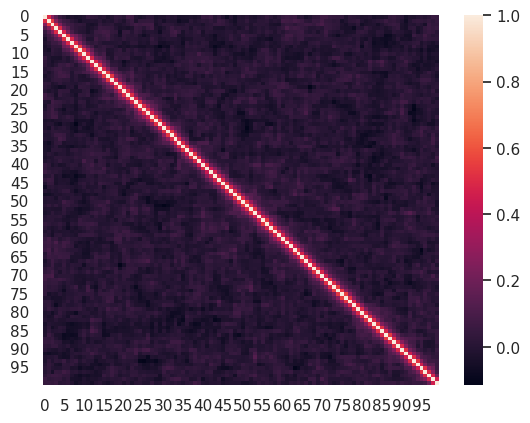

In [24]:
sns.heatmap(np.corrcoef(data[:, 2:].T))

In [25]:
# Initialize the FacetGrid object
#plt.axvline(x=1, ls='--', color='black')
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
kde_ridgeplot(result_df_long, 'method', 'estimate', pal, figsize=(6, 4))
#plt.xlim(0.5, 2)

NameError: name 'result_df_long' is not defined

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet("/home/tliu/learning-ivs/tmp_lennon100/train/uid=0-treatment_effect=-1.1086778243435313-n_samples=1000.parquet")

In [ ]:
df.dtypes

T      float32
Y      float32
Z0     float32
Z1     float32
Z2     float32
        ...   
Z95    float32
Z96    float32
Z97    float32
Z98    float32
Z99    float32
Length: 102, dtype: object